In [20]:
import numpy as np
import matplotlib.pyplot as plt

from CMEP import CMEP_Atom
from CMEP_TwoElectron import Two_Electron_Plasma
from hnc import  HNC_solver
from qsps import *

from pandas import read_csv

eV = 0.0367512


In [21]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ni_cc = 1e22
Te_eV = 5.56
Te_AU = Te_eV*eV 
Ti_eV = Te_eV

Z, A = 4,9
Zbar= 2.105

atom_old = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'svt'},
             hnc_solve_options={'alpha_Picard':1})
# atom.run_hnc()
print("T/EF = ", atom.qsp.Ti/atom.qsp.E_F)

Te_in_eV: 5.560
Ti_in_eV: 5.560
T/EF =  2.00013194113309


In [25]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ni_cc = 1e22
Te_eV = 5.56
Te_AU = Te_eV*eV 
Ti_eV = Te_eV

Z, A = 4,9
Zbar= 2.105

atom = Two_Electron_Plasma(Z, A, ni_cc, Ti_eV, Te_eV, n_up_fraction=0.5, Zbar=Zbar,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'svt'},
             hnc_solve_options={'alpha_Picard':0.5})
# atom.run_hnc()
print("T/EF = ", atom.qsp.Ti/atom.qsp.E_F)

Te_in_eV: 5.560
Ti_in_eV: 5.560
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
T/EF =  2.00013194113309


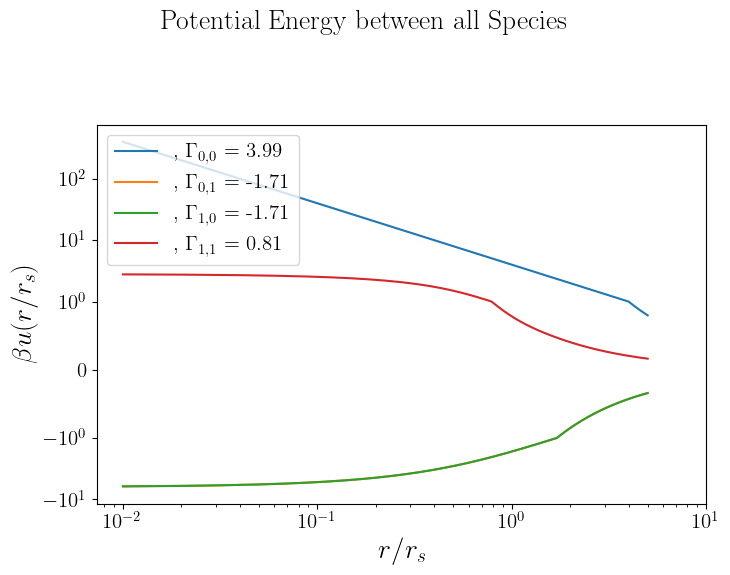

In [26]:
atom_old.hnc.plot_βu_all_species()

/home/zach/plasma/hnc/hnc_Ng.py:1012: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,10)


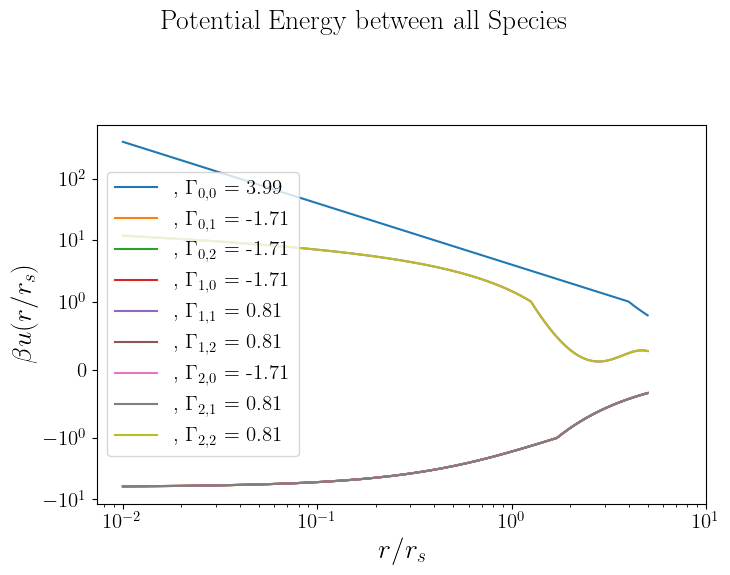

In [9]:
atom.hnc.plot_βu_all_species()

In [27]:
atom.run_hnc()

0: Initial condition Total Error: 2.847e+00
QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 0
Final iter:11, Total Error: 1.848e+00
QUIT: Picard Err too high. Newton assumed not to converge. Try better initial condition or smaller α.


# Invert HNC

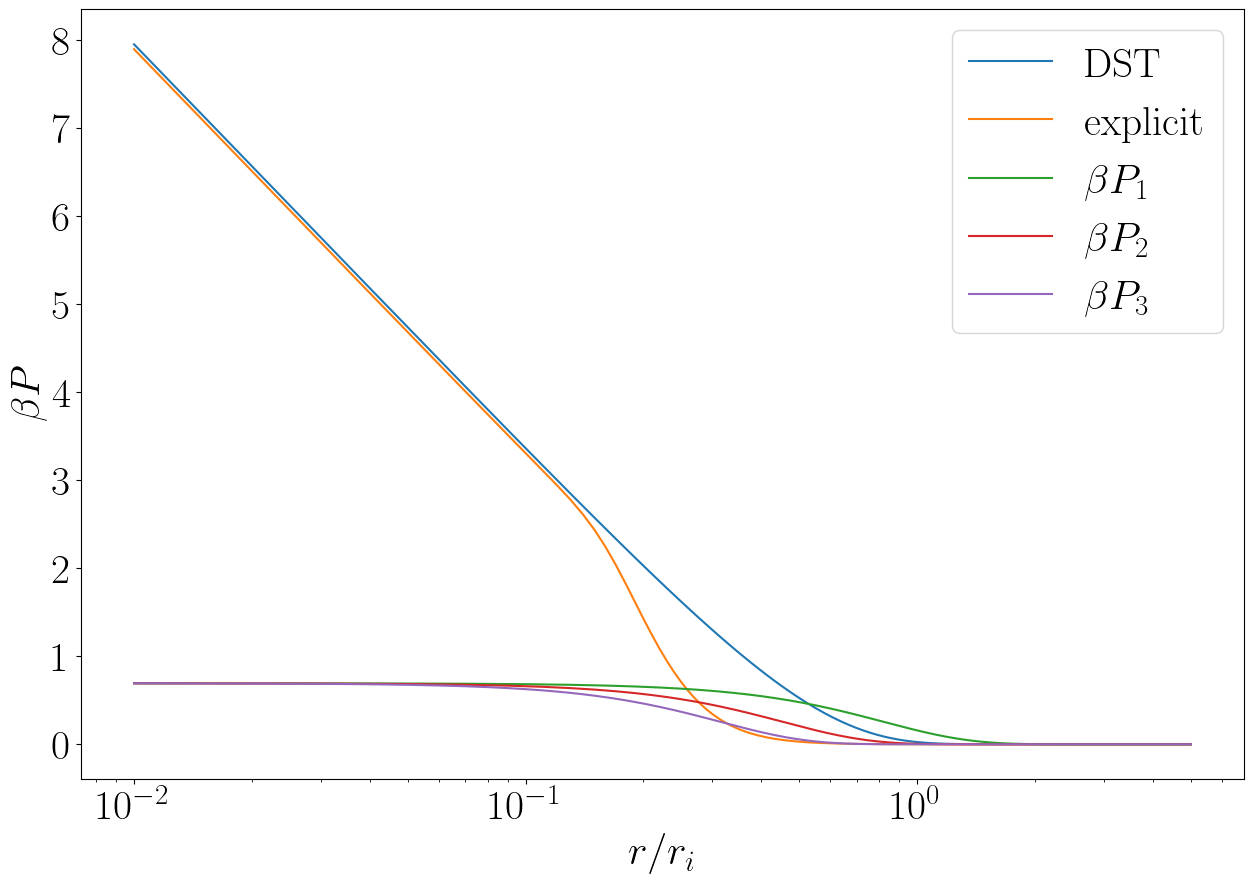

In [139]:
fig, ax = plt.subplots()

ax.plot(atom.hnc.r_array, β_cP_DST, label='DST')
ax.plot(atom.hnc.r_array, β_cP_explicit,label='explicit')
ax.plot(atom.hnc.r_array, qsp.βv_Pauli(atom.hnc.r_array, qsp.Λee),label=r'$\beta P_1$')
Λee_test = 1/np.sqrt(2*π*(m_e/2)*atom.qsp.Te_c )/atom.qsp.ri 
ax.plot(atom.hnc.r_array, np.log(2)*np.exp(-np.log(2)*atom.hnc.r_array**2/(π*Λee_test**2)),label=r'$\beta P_2$'  )
ax.plot(atom.hnc.r_array, np.log(2)*np.exp(-atom.hnc.r_array**2/(π*np.log(2)*Λee_test**2)),label=r'$\beta P_3$'  )
# ax.set_yscale('log')
ax.set_xscale('log')

# ax.set_ylim(1e-1,1e0)
ax.set_ylabel(r'$\beta P$')
ax.set_xlabel(r'$r/r_i$')
ax.legend()

In [51]:
from scipy.special import erfc

def Slater_S(Γ):
    ymax = 100
    ymin = 0.01*π*np.sqrt(Γ*qsp.re)
    N = int(ymax/ymin)
    print(N)
    y = np.linspace(0,1e2,num=N)
    dy = y[1]-y[0]
    return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )

def β_cΔ(Γ, x): 
    """
    x=r/r_e   
    """
    a = np.sqrt(qsp.re/Γ)
    γ = -np.sqrt(π*Γ*qsp.re)/np.log(Slater_S(Γ))
#     return Γ/x*( 1 - np.exp(-a**2*x**2) + np.sqrt(π)*a*x *erfc(a*x))
    return Γ/x*( 1 - np.exp(-a**2*x**2) + np.sqrt(π)*a*x/γ *erfc(γ*a*x))
    
def Γc():
    Γ = 1/(qsp.Te*qsp.re)
    ωp = np.sqrt(4*π*qsp.ne/m_e)
    return 2*Γ*qsp.Te * np.tanh(ωp/(2*qsp.Te))/( ωp  )

1710


/tmp/ipykernel_7200/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


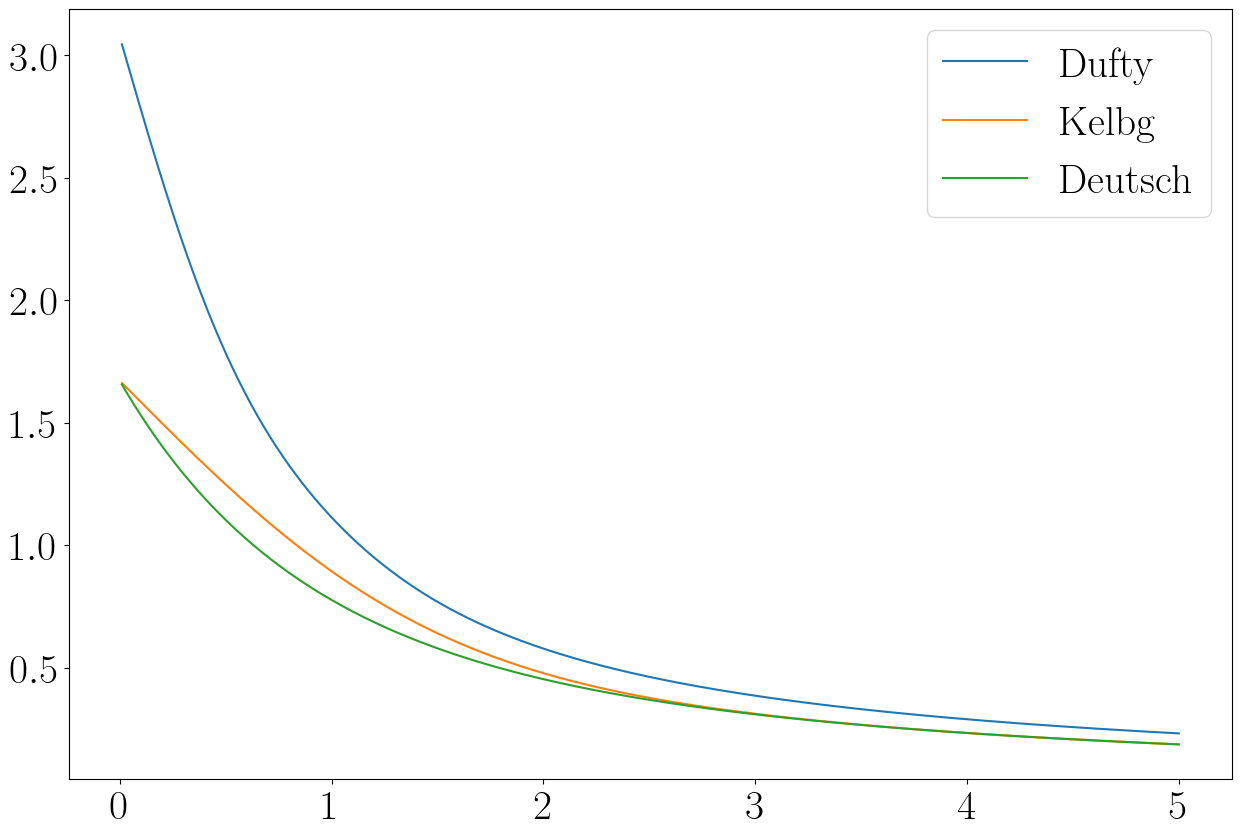

In [53]:
fig, ax = plt.subplots()

ax.plot(atom.hnc.r_array, β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re ),label= "Dufty")
ax.plot(atom.hnc.r_array, qsp.βv_Kelbg(qsp.Γee, atom.hnc.r_array, qsp.Λee), label='Kelbg')
ax.plot(atom.hnc.r_array, qsp.βv_Deutsch(qsp.Γee, atom.hnc.r_array, qsp.Λee),label='Deutsch')
# ax.plot(atom.hnc.r_array, qsp.βv_Kelbg(Γc(), atom.hnc.r_array, qsp.Λee))
ax.legend()

In [20]:
np.savetxt("βvee.txt",np.array([atom.hnc.r_array, β_cP_DST + β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re )]).T)

1710


/tmp/ipykernel_42832/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


In [13]:
βu_r_matrix = np.array([[β_cP_DST + β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re ) ]])

atom.hnc.set_βu_matrix(βu_r_matrix)
atom.hnc.initialize_c_k()
atom.hnc.set_C_matrix()
atom.hnc.HNC_solve(alpha_method='best', alpha_Picard = 1e-2, alpha_oz = 1e-4, h_max=1e4)
h_r_DST = atom.hnc.h_r_matrix[0,0]

βu_r_matrix = np.array([[β_cP_explicit + β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re ) ]])

atom.hnc.set_βu_matrix(βu_r_matrix)
atom.hnc.initialize_c_k()
atom.hnc.set_C_matrix()
atom.hnc.HNC_solve(alpha_method='best', alpha_Picard = 1e-2, alpha_oz = 1e-4, h_max=1e4)
h_r_explicit = atom.hnc.h_r_matrix[0,0]

1710
 HNC min: [0.5] True Optimization terminated successfully.
0: Err in c_r: 7.19e-02, OZ: 1.01e-01, HNC: 1.88e-02
 HNC min: [0.5] True Optimization terminated successfully.
1: Err in c_r: 4.28e-02, OZ: 1.04e-01, HNC: 9.86e-03
 HNC min: [0.5] True Optimization terminated successfully.
2: Err in c_r: 2.55e-02, OZ: 1.06e-01, HNC: 5.58e-03
 HNC min: [0.5] True Optimization terminated successfully.
3: Err in c_r: 1.53e-02, OZ: 1.07e-01, HNC: 3.30e-03
 HNC min: [0.5] True Optimization terminated successfully.
4: Err in c_r: 9.24e-03, OZ: 1.08e-01, HNC: 2.00e-03
 HNC min: [0.5] True Optimization terminated successfully.
5: Err in c_r: 5.63e-03, OZ: 1.08e-01, HNC: 1.24e-03
 HNC min: [0.5] True Optimization terminated successfully.
6: Err in c_r: 3.45e-03, OZ: 1.08e-01, HNC: 7.72e-04
 HNC min: [0.5] True Optimization terminated successfully.
7: Err in c_r: 2.13e-03, OZ: 1.09e-01, HNC: 4.87e-04


/tmp/ipykernel_42832/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


 HNC min: [0.5] True Optimization terminated successfully.
8: Err in c_r: 1.33e-03, OZ: 1.09e-01, HNC: 3.09e-04
 HNC min: [0.5] True Optimization terminated successfully.
9: Err in c_r: 8.34e-04, OZ: 1.09e-01, HNC: 1.97e-04
 HNC min: [0.5] True Optimization terminated successfully.
10: Err in c_r: 5.25e-04, OZ: 1.09e-01, HNC: 1.26e-04
 HNC min: [0.5] True Optimization terminated successfully.
11: Err in c_r: 3.33e-04, OZ: 1.09e-01, HNC: 8.06e-05
 HNC min: [0.5] True Optimization terminated successfully.
12: Err in c_r: 2.11e-04, OZ: 1.09e-01, HNC: 5.17e-05
 HNC min: [0.5] True Optimization terminated successfully.
13: Err in c_r: 1.35e-04, OZ: 1.09e-01, HNC: 3.33e-05
 HNC min: [0.5] True Optimization terminated successfully.
14: Err in c_r: 8.62e-05, OZ: 1.09e-01, HNC: 2.14e-05
 HNC min: [0.5] True Optimization terminated successfully.
15: Err in c_r: 5.52e-05, OZ: 1.09e-01, HNC: 1.38e-05
 HNC min: [0.5] True Optimization terminated successfully.
16: Err in c_r: 3.54e-05, OZ: 1.09e-01,

(0.0, 1.5)

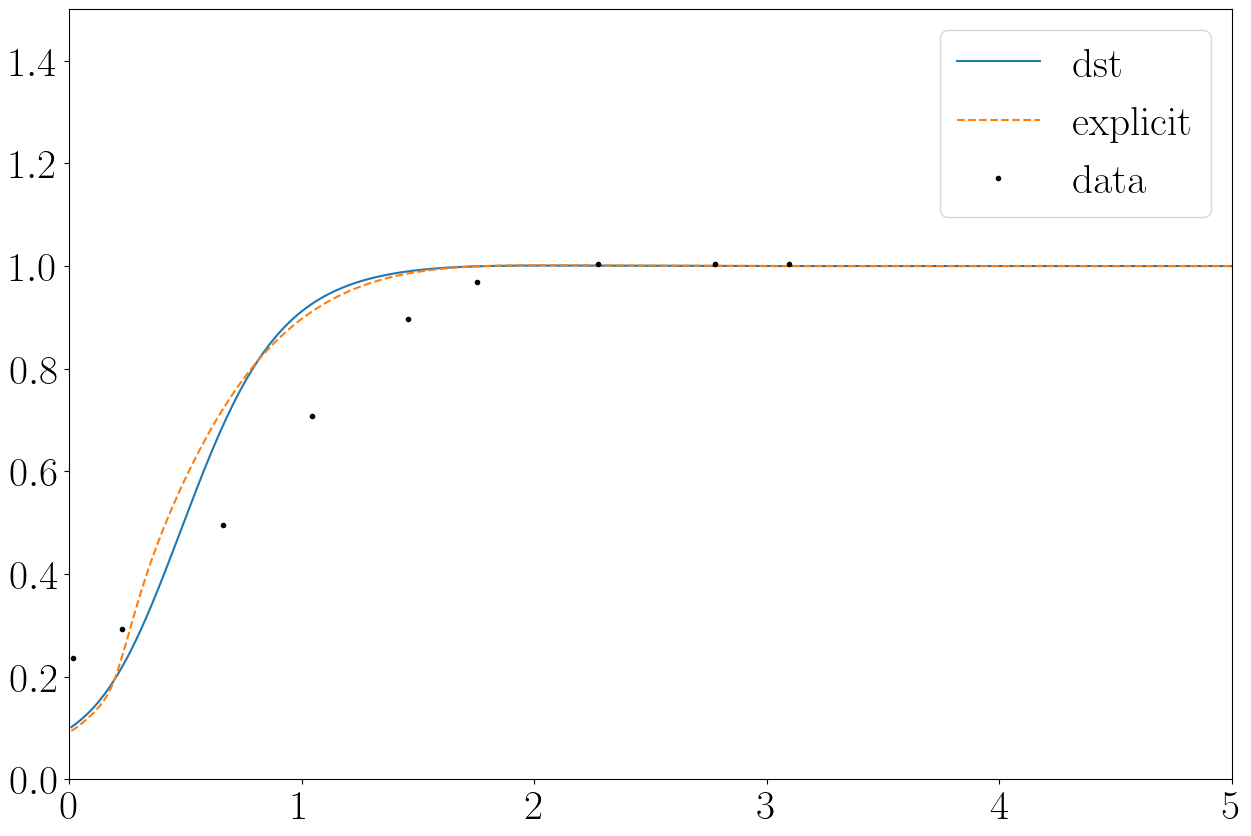

In [14]:
fig, ax = plt.subplots()
DD_data_rs1_t1 = np.array([[0.015915119363395226, 0.22208955223880597],
[0.16710875331564987, 0.2740298507462687 ],
[0.42572944297082227, 0.4298507462686567 ],
[0.7519893899204244, 0.6698507462686567 ],
[1.0145888594164456, 0.8202985074626866 ],
[1.3647214854111407, 0.9223880597014925 ],
[1.9456233421750664, 0.9779104477611941 ],
[2.944297082228117, 1.0011940298507462  ]]).T

DD_data_rs40_t8 = np.array([[0.09767441860465116, 0.002628120893561104 ],
[0.3697674418604651, 0.02759526938239159  ],
[0.5895348837209302, 0.16294349540078845  ],
[0.8093023255813954, 0.4231274638633377  ],
[1.0186046511627906, 0.6649145860709593  ],
[1.1651162790697673, 0.7936925098554534  ],
[1.3813953488372093, 0.9132720105124836  ],
[1.744186046511628, 0.9894875164257556  ],
[2.644186046511628, 1.0052562417871223  ]]).T

DD_data_rs1_t0p0625 = np.array([[0.015810276679841896, 0.2360060514372163],
[0.2292490118577075, 0.291981845688351   ],  
[0.6600790513833992, 0.4962178517397882  ],  
[1.0434782608695652, 0.708018154311649   ], 
[1.4584980237154148, 0.897125567322239   ],  
[1.7549407114624505, 0.9697428139183056  ], 
[2.276679841897233, 1.0030257186081695   ],
[2.7786561264822134, 1.0030257186081695  ], 
[3.0948616600790513, 1.0030257186081695  ]]).T

ax.plot(atom.hnc.r_array, h_r_DST+1,'-', label='dst')
ax.plot(atom.hnc.r_array, h_r_explicit+1,'--',label='explicit')
# ax.plot(DD_data_rs1_t1[0],DD_data_rs1_t1[1],'k.',label='data')
# ax.plot(DD_data_rs40_t8[0],DD_data_rs40_t8[1],'k.',label='data')
ax.plot(DD_data_rs1_t0p0625[0],DD_data_rs1_t0p0625[1],'k.',label='data')
ax.legend()
ax.set_xlim(0,5)
ax.set_ylim(0,1.5)